In [1]:
library(caret)
library(glmnet)

Loading required package: lattice
Loading required package: ggplot2
Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16



In [2]:
coin_data <- read.csv("../imp_coin.csv")[-c(1,2,4,5,6,8)]
coin_data_test <-read.csv("../imp_coin_test.csv")[-c(1,2,4,5,6,8)]

Training sample

In [3]:
set.seed(1)
training.samples <- createDataPartition(coin_data$btc_price, p = 0.8, list = FALSE)
train.data  <- coin_data[training.samples, ]
test.data <- coin_data[-training.samples, ]

x <- model.matrix(btc_price~., train.data)[,-1]
y <- as.double(train.data$btc_price)
x.test <- model.matrix(btc_price ~., test.data)[,-1]

k-fold Cross Validation, nb = 10

In [4]:
lambdas_to_try <- 10^seq(-3, 10, length.out = 100)
set.seed(1) 
cv.lasso <- cv.glmnet(x, y, alpha = 1, type.measure='mse', lambda = lambdas_to_try, nfolds = 10)

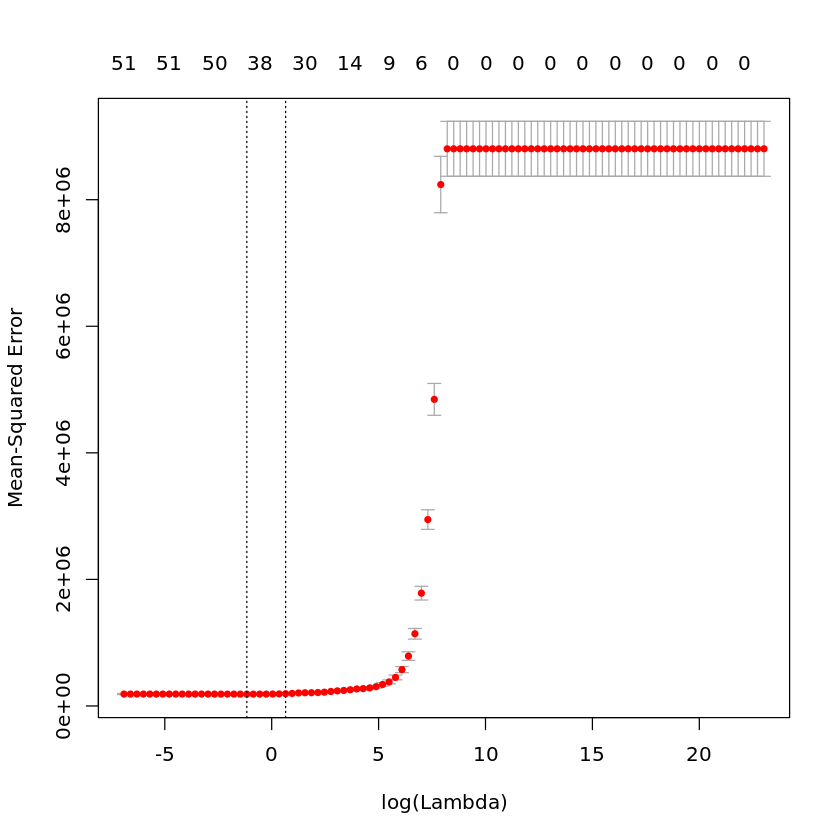

In [5]:
plot(cv.lasso)

In [6]:
cv.lasso$lambda.min

[1] 0.3125716

In [7]:
cv.lasso$lambda.1se

[1] 1.91791

In [8]:
model_10_nfolds <- glmnet(x, y, alpha = 1, family = "gaussian", lambda = cv.lasso$lambda.min)
pred_10 = predict(model_10_nfolds, newx = x.test)

# k-fold Cross Validation, nb = 5

In [9]:
lambdas_to_try <- 10^seq(-3, 10, length.out = 100)
set.seed(1)
cv.lasso <- cv.glmnet(x, y, alpha = 1, type.measure='mse', lambda = lambdas_to_try, nfolds = 5)

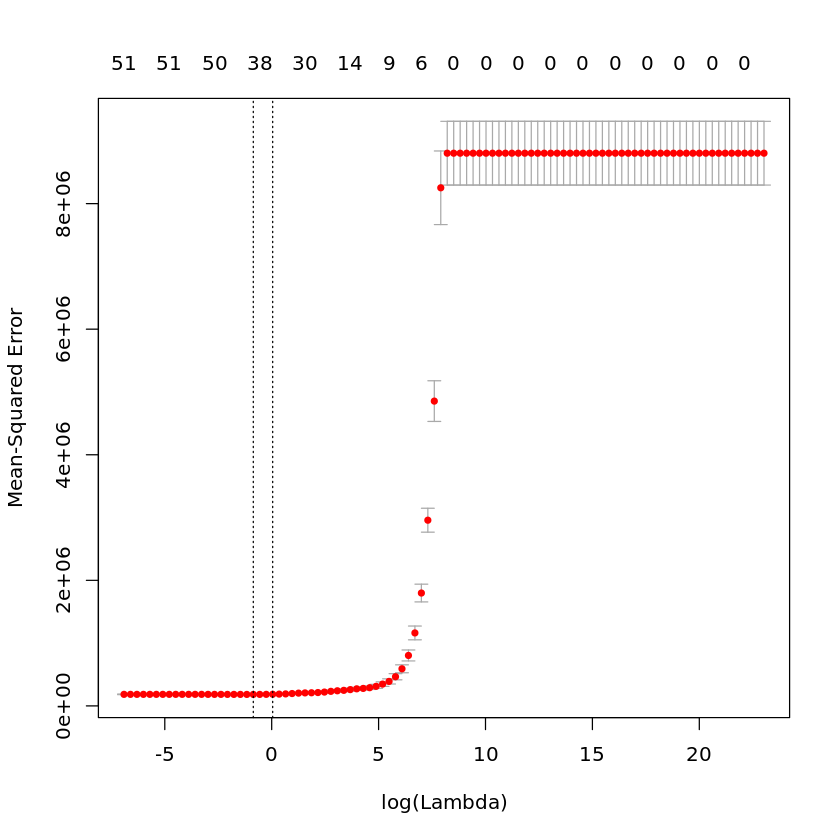

In [10]:
plot(cv.lasso)

In [11]:
cv.lasso$lambda.min

[1] 0.4229243

In [12]:
cv.lasso$lambda.1se

[1] 1.047616

lambda min of k-fold Cross Validation nb = 5 > k-fold Cross Validation nb = 10

In [13]:
# Fit the final model on the training data
model_5_nfolds <- glmnet(x, y, alpha = 1, family = "gaussian", lambda = cv.lasso$lambda.min)
pred_5 = predict(model_5_nfolds, newx = x.test)

In [14]:
model_5_nfolds


Call:  glmnet(x = x, y = y, family = "gaussian", alpha = 1, lambda = cv.lasso$lambda.min) 

     Df   %Dev Lambda
[1,] 50 0.9816 0.4229

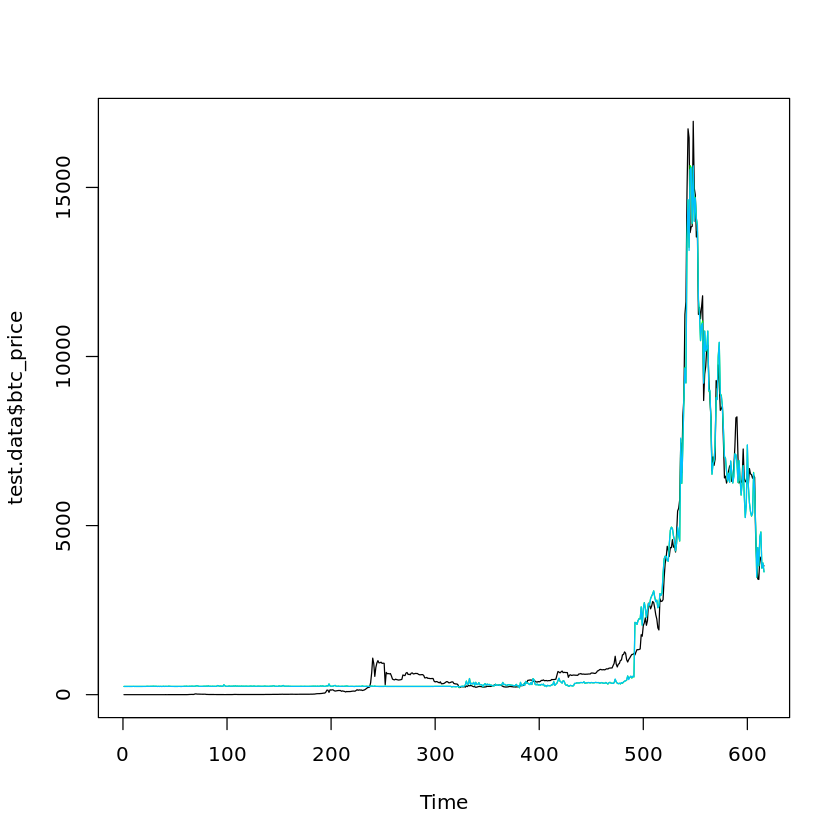

In [15]:
plot.ts(test.data$btc_price)
lines(pred_5, col="green")
lines(pred_10, col="deepskyblue")

In [16]:
mean((test.data$btc_price - pred_5)^2)

[1] 177342.3

In [17]:
mean((test.data$btc_price - pred_10)^2)

[1] 176646.1